<div align="center">

<font size="5">

Laboratorium z przedmiotu: \
**Głębokie uczenie i analiza obrazów**

Ćwiczenie 3: \
**Konwolucyjne sieci neuronowe**

</font>

\
Marta Szarmach \
Zakład Telekomunikacji Morskiej \
Wydział Elektryczny \
Uniwersytet Morski w Gdyni

09.2023
</div>



# 1. Wprowadzenie

**Konwolucyjne sieci neuronowe** (ang. *convolutional neural networks*, CNN) to sieci, których działanie opiera się na konwolucji. W skrócie, sygnał dostarczony do sieci neuronowej (np. zdjęcie) analizowany jest fragment po fragmencie poprzez wykonanie konwolucji (wymnożenia i zsumowania) tegoż fragmentu z pewnym **filtrem** (ang. *kernel*). Zadaniem filtra jest (poprzez konwolucję) rozpoznanie w analizowanym sygnale pewnych cech (np. krawędzi), a na późniejszych etapie nawet pewnych obiektów. To właśnie na zawartość filtra składają się parametry sieci konwolucyjnej, wyznaczane w ramach jej treningu. 

Z racji swojej budowy i działania, konwolucyjne sieci neuronowe znalazły szerokie zastosowanie w analizie obrazów. Obrazy są najczęściej przedstawiane w formie 3-kanałowych macierzy (RGB), a następnie poddawane są konwolucji z filtrami, na którą wzór można zapisać tak:
\begin{equation*}
    (A * H)[m,n] = \sum_j \sum_k H[j,k] \cdot A[m-j,n-k]
\end{equation*}
Każdy filtr ma za zadanie wykryć pewną konkretną cechę/zawartość analizowanego fragmentu obrazu. Zaczyna się zazwyczaj od odnajdywania prostych elementów, takich, jak krawędzie, a następnie, na kolejnych warstwach, sieć jest w stanie wykrywać coraz bardziej złożone kształty i obiekty. Zazwyczaj z każdą kolejną warstwą konwolucyjną zwiększa się ilość kanałów sygnału (tj. wykrywa się więcej kształtów).

<div align="center">

<img src='https://i0.wp.com/developersbreach.com/wp-content/uploads/2020/08/cnn_banner.png?fit=1400%2C658&ssl=1'/>

<font size="1">Grafika: developersbreach.com</font>
</div>

Typowa budowa sieci konwolucyjnej przedstawiona jest na powyższym rysunku. Zazwyczaj sieci te buduje się z kilku występującycj po sobie bloków, złożonych z warstwy konwolucyjnej (wykonującej właściwą konwolucję), warstwy aktywacyjnej (np. ReLU) oraz innych, takich jak *dropout* czy *BatchNorm*. Na końcu sieci znajduje się najczęściej warstwa Flatten, która sprowadza dane dlań wejściowe do postaci 1-wymiarowego tensora, a za nią dane te przekształcane są przez jedną bądź kilka warstw liniowych. Na końcu sieci występuje warstwa przeprowadzająca ostateczną predykcję - w zależności od rozwiązywanego problemu, może to być Sigmoid, Softmax, itp.

Pomiędzy blokami konwolucyjnymi możemy użyć także dodatkowej warstwy, zwanej *pooling layer*, która ma na celu zmiejszenie wymiaru ,,obrazu'' przekazywanego do następnej warstwy. Mamy fo wyboru:
* *max pooling* - grupa pikseli zastępowana jest jednym, o wartości największej z grupy,
* *average pooling* - grupa pikseli zastępowana jest jednym, o wartości średniej całej grupy.

Hiperparametrami regulującymi działanie konwolucyjnych sieci neuronowych, które nie występowały w ,,zwykłych'' sieciach neuronowych (opartych na warstwach liniowych), są:
* *kernel_size* - wielkość filtra,
* *padding* - określa, jak „szeroka” ma być dodana (na dowolnej warstwie) do obrazu ramka z zer, co ma przeciwdziałać nadmiernemu zmiejszaniu się wymiarów obrazu wraz z kolejnymi konwolucjami, a także umożliwić dokładniejszą analizę brzegów obrazu,
* *stride* - określa, za ile pikseli filtr wykona następną konwolucję.



# 2. Cel ćwiczenia

**Celem niniejszego ćwiczenia** jest zapoznanie się z budową i działaniem konwolucyjnych sieci neuronowych poprzez:
* implementacji architektury pewnej konwolucyjnej sieci neuronowej o niewielkiej ilości warstw z wykorzystaniem biblioteki PyTorch i języka programowania Python,
* skorzystanie z implementacji gotowej sieci konwolucyjnej, realizującej klasyfikację obrazów - AlexNet.


# 3. Stanowisko laboratoryjne

Do wykonania niniejszego ćwiczenia niezbędne jest stanowisko laboratoryjne, składające się z komputera klasy PC z zainstalowanym oprogramowaniem:
* językiem programowania Python (w wersji 3.8),
* IDE obsługującym pliki Jupyter Notebook (np. Visual Studio Code z rozszerzeniem ipykernel).


# 4. Przebieg ćwiczenia
## 4.1. Implementacja konwolucyjnej sieci neuronowej z wykorzystaniem biblioteki PyTorch

Na początku wykonaj poniższy fragment kodu, aby zaimportować biblioteki niezbędne do wykonania poniższego ćwiczenia:
* **PyTorch** - biblioteka wspomagająca budowanie architektur sieci neuronowych, posiadająca wbudowane moduły odpowiadające różnym warstwom sieci neuronowych, automatyczne obliczanie gradientów (*autograd*) niezbędne do przeprowadzenia treningu sieci neuronowych,
* **NumPy** - biblioteka umożliwiająca wykonywanie wysoko zoptymalizowanych obliczeń matematycznych na objektach typu *numpy array* (wielowymiarowych tablic),
* **Matplotlib** - biblioteka wspomagająca wizualizację pracy czy analizę danych poprzez wyświetlanie wykresów,
* **Scikit-learn** - biblioteka zawierająca gotowe implementacje wielu algorytmów klasycznego uczenia maszynowego, a także zbiory danych czy metryki; tutaj skorzystamy ze zbioru danych MNIST - `datasets.load_digits` oraz metody `model_selection.train_test_split` służącej do podziału danych na zestaw treningowy i testowy,
* **Optuna** - biblioteka zawierająca narzędzia automatyzujące optymalizację danej funkcji.

In [2]:
# ! python -m pip install torch==2.0.1
# ! python -m pip install numpy==1.22.3
# ! python -m pip install scikit-learn==0.24.2
# ! python -m pip install matplotlib==3.4.2
# ! python -m pip install optuna

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import optuna
# (dla zachowania powtarzalności wyników)
np.random.seed(10) 
torch.manual_seed(10)

### Wczytanie i przygotowanie danych

Na początku przygotujmy dane, na których będziemy dziś pracować. Tym razem korzystać będziemy ze zbioru MNIST, zawierającego *num_samples* = 1797 obrazków o rozmiarze 8x8, przedstawiających odręcznie pisane cyfry. Uruchom kod z poniższej komórki, aby:
* wczytać oryginalne dane z zestawu MNIST (`digits`) do zmiennej $X$ i ich etykiety do zmiennej $y$,
* obliczyć (z wykorzystaniem metody `numpy.unique`) w automatyczny sposób ilość klas występujących w naszym zbiorze danych (tj. ilość unikalnych wartości w etykietach) - wiemy, że powinno ich być 10, tyle, ile cyfr,
* z pomocą `train_test_split` wydzielić 70% obrazków jako zestaw treningowy $Xtrain$, a pozostałą część danych po równo podzielić na zestaw walidacyjny $Xval$ i testowy $Xtest$ (po 15%),
* przygotować etykiety tak, aby współpracowały z funkcją kosztu `CrossEntropyLoss`, którą zastosujemy przy treningu naszej sieci - odpowiedź od każdego neuronu zbierana będzie w osobnej kolumnie tablicy, dlatego nasze etykiety w formacie (*num_samples*,), zawierające wartości 0,1,...9 przekształcimy za pomocą one-hot-encodingu do postaci (*num_samples*, *num_classes*), np. 2 -> [0,0,1]
* ostatecznie, dane i przekształcone etykiety, które będą przekazywane sieci neuronowej, przekształcić do formatu `torch.tensor`, aby były zrozumiałe dla PyTorcha; jednocześnie wyodrębniając w danych jako drugi wymiar ilość kanałów (w tym przypadku jest to 1): nasze dane wejściowe mają teraz kształt (*num_samples*, *num_channels*, *sample_size*, *sample_size*), gdzie *num_channels* = 1 (dla obrazów RGB byłoby to 3), *sample_size*=8.

In [3]:
# --------------------------- Inicjalizacja ----------------------------
# Wczytanie danych
digits = load_digits()
X = digits.images
y = digits.target
num_classes = (np.unique(y)).shape[0]
# Podziel dane na zestaw treningowy (70%), walidacyjny (15%) i testowy (15%) z wykorzystaniem metody train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,train_size=0.6)
Xval, Xtest, yval, ytest = train_test_split(Xtest,ytest,train_size=0.5)
# Dokonaj one-hot-encodingu etykiet z zestawu treningowego i walidacyjnego
ytrain_ohe = np.identity(num_classes)[ytrain]
yval_ohe = np.identity(num_classes)[yval]
# Przekonwertuj dane wejściowe na tensory, by mogłby być obsługiwane przez PyTorch
# i jednocześnie wydziel wymiar 1 jako ilość kanałów
Xtrain = torch.tensor(Xtrain.reshape(-1, 1, Xtrain.shape[1], Xtrain.shape[2]))
ytrain_ohe = torch.tensor(ytrain_ohe) 
Xval = torch.tensor(Xval.reshape(-1, 1, Xval.shape[1], Xval.shape[2])) 
yval_ohe = torch.tensor(yval_ohe)
Xtest = torch.tensor(Xtest.reshape(-1, 1, Xtest.shape[1], Xtest.shape[2]))

### Określenie struktury naszej sieci neuronowej

W kolejnym kroku zdefiniujemy strukturę naszej konwolucyjnej  sieci neuronowej, korzystając z klas dostępnych w bibliotece PyTorch! Tak samo, jak ostatnio, zrobimy to w naszej własnej klasie - nazwijmy ją `ConvNet` - która musi dziedziczyć z klasy `torch.nn.Module`, w której umieścimy dwie metody:
* metodę-konstruktor `__init__()` - opisującą budowę sieci; skorzystamy tu ze znanych już wcześniej warstw `torch.nn.Linear`, `torch.nn.ReLU`, `torch.nn.Dropout`, `torch.nn.Softmax` czy `torch.nn.Sequential`, ale użyjemy także kilku nowych, charakterystycznych dla konwolucyjnych sieci neuronowych:
    * `torch.nn.Conv2d` - ([TUTAJ](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) - realizująca właściwą konwolucję pomiędzy filtrami a fragmentami obrazów; wymaga takich argumentów, jak: ilość kanałów wejściowych/wyjściowych, wielkość filtra, *padding*, *stride*,
    * `torch.nn.BatchNorm` - ([TUTAJ](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)) i ([TUTAJ](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)) - realizująca normalizację wsadową, zarówno na obrazach (2d), jak i na 1-wymiarowych tensorach (1d),
    * `torch.nn.Flatten` - ([TUTAJ](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)) - realizująca ,,wypłaszczenie'' wejściowego sygnału 2d do postaci 1-wymiarowego tensora.
* metodę `forward()` - w której określamy przepływ danych pomiędzy warstwami.

Uzupełnij zatem poniższy kod! Oto założenia:
* Niech nasza sieć neuronowa składa się z następujących warstw:

2 x (`Conv2d` -> `BatchNorm2d` -> `Dropout` -> `ReLU`) -> `Flatten` -> `Linear` -> `BatchNorm1d` -> `Dropout` -> `Softmax`.
* Podczas pierwszej konwolucji, niech wyznaczonych zostanie 16 kanałów, a po drugiej - 32 (ilość kanałów przechowywana jest w tablicy `num_conv_channels`).
* Prawdopodobieństwo odrzucenia neuronu przez `dropout` niech wynosi 0,25.

Wskazówki:
* Po każdej konwolucji, wymiary obrazu (szerokość i długość) zmieniają się zgodnie z poniższym wzorem:
\begin{equation*}
    sample\_size_{\textrm{new}} = \frac{sample\_size_{\textrm{original}} + 2 \cdot padding - kernel\_size}{stride} + 1 
\end{equation*}
* Zastanów się, jak długi tensor zwróci nam warstwa ```Flatten``` (będzie Ci to potrzebne do właściwej inicjalizacji warstwy ```Linear```) - do policzenia tego, na pewno będziesz potrzebować wymiaru obrazka po ostatniej konwolucji, a także ilości kanałów po tejże konwolucji!
* `BatchNorm2d` jako argument  `num_features` wymaga ilości kanałów w analizowanych przezeń danych, natomiast `BatchNorm1d` - ilość neuronów z ostatniej warstwy Linear.
* Wszystkie niezbędne dane przekazywać będziemy konstruktorowi jako argumenty.

In [32]:
class ConvNet(torch.nn.Module):
    """
    Model konwolucyjnej sieci neuronowej:
    (Conv -> BatchNorm -> Dropout -> ReLU) -> (Conv -> BatchNorm -> Dropout -> ReLU) -> (Flatten -> Linear -> BatchNorm -> Dropout -> Softmax)
    """
    
    def __init__(self, input_channels, sample_size, output_layer_size, kernel_size, padding, stride):
        """
        Definiuje budowę sieci. Argumenty: \n
        - input_channels - ilość kanałów w wejściowych obrazkach (skalar, int)
        - sample_size - długość/szerokość wejściowego obrazka (skalar, int)
        - output_layer_size - ilość neuronów na ostatniej warstwie (skalar, int)
        - kernel_size - wielkość filtra do konwolucji (skalar, int)
        - padding - ,,grubość'' ramki z zer dodowananej do obrazka (skalar, int)
        - stride - co ile pikseli obrazka wykonywana jest konwolucja (skalar, int)
        """
        super().__init__()
        num_conv_channels = [16, 32] # Do dowolnej modyfikacji - ilość kanałów po kolejnych konwolucjach
        # ---------------------- UZUPEŁNIJ KOD -----------------------------------
        # Oblicz rozmiary obrazków po pierwszej konwolucji
        size1 = ((sample_size + 2 * padding - kernel_size) / stride) + 1
        # Oblicz rozmiary obrazków po drugiej konwolucji
        size2 = int(((size1 + 2 * padding - kernel_size) / stride) + 1)
        # Zacznij definiować budowę sieci:
        self.first_layer = torch.nn.Sequential(
            # Warstwa konwolucyjna
            torch.nn.Conv2d(
                 in_channels=input_channels,
                 out_channels=num_conv_channels[0],
                 kernel_size=kernel_size,
                 padding=padding,
                 stride=stride
            ),
            # BatchNorm2d
            torch.nn.BatchNorm2d(num_features=num_conv_channels[0]),
            # Dropout (niech neuron zostanie usunięty z prawdopodobieństwem 0.25)
            torch.nn.Dropout(0.25),
            # Funkcja aktywacji ReLU
            torch.nn.ReLU() 
        )
        self.second_layer = torch.nn.Sequential(
            # Warstwa konwolucyjna
            torch.nn.Conv2d(
                 in_channels=num_conv_channels[0],
                 out_channels=num_conv_channels[1],
                 kernel_size=kernel_size,
                 padding=padding,
                 stride=stride
            ),
            # BatchNorm2d
            torch.nn.BatchNorm2d(num_features=num_conv_channels[1]),
            # Dropout (niech neuron zostanie usunięty z prawdopodobieństwem 0.25)
            torch.nn.Dropout(0.25),
            # Funkcja aktywacji ReLU
            torch.nn.ReLU() 
        )
        self.third_layer = torch.nn.Sequential(
            # Flatten
            torch.nn.Flatten(),
            # Linear
            torch.nn.Linear(
                 in_features=size2 * size2 * 32,
                 out_features=output_layer_size
            ),
            # BatchNorm1d
            torch.nn.BatchNorm1d(num_features=output_layer_size),
            # Dropout
            torch.nn.Dropout(0.25),
            # Softmax
            torch.nn.Softmax(dim=1)
        )
        # ---------------------------------------------------------------------

    def forward(self, X):
            """ 
            Definiuje przepływ danych w sieci. \n
            Argument: X - dane wejściowe, obrazki w postaci torch.tensor, shape=(num_samples, input_channels, sample_size, sample_size) \n
            Zwraca: X - odpowiedź sieci w postaci prawdopodobieństw, torch.tensor, shape=(sum_samples, num_classes)
            """
            # ------------------- UZUPEŁNIJ KOD ----------------
            X = self.first_layer(X)
            X = self.second_layer(X)
            X = self.third_layer(X)
            # --------------------------------------------------
            return X

Spróbujmy utworzyć obiekt stworzonej przez nas klasy ConvNet i wykonać jakiś próbny *forward pass* na danych walidacyjnych, aby przekonać się, czy budowa naszej sieci jest poprawna (przynajmniej pod kątem składnowym i numerycznym, tj. czy zgadzają się wymiary tensorów przekazywanych pomiędzy warstwami). Uruchom więc kod z poniższej komórki. 

In [33]:
cnn = ConvNet(
    input_channels=1,
    sample_size=Xval.shape[2],
    output_layer_size=num_classes,
    kernel_size=3,
    padding=0,
    stride=1)
cnn = cnn.double()
pred = cnn(Xval)
print("Przykładowe predykcje modelu na danych walidacyjnych: "+str(pred[0:3]))

Przykładowe predykcje modelu na danych walidacyjnych: tensor([[0.1337, 0.1067, 0.0210, 0.1159, 0.0591, 0.0370, 0.1159, 0.1397, 0.1550,
         0.1159],
        [0.0521, 0.0521, 0.0728, 0.0962, 0.0058, 0.5199, 0.0042, 0.0101, 0.0042,
         0.1825],
        [0.1179, 0.0907, 0.0069, 0.0938, 0.0440, 0.0440, 0.0527, 0.1734, 0.3579,
         0.0186]], dtype=torch.float64, grad_fn=<SliceBackward0>)


Zbieramy odpowiedzi od każdego wyjściowego neuronu, a każda oznacza prawdopodobieństwo przynależności badanego obrazka do odpowiedniej klasy. Pamiętaj, że nie ma po co przywiązywać się do predykcji otrzymanych na tym etapie - sieć jeszcze nie została niczego nauczona! 


### Trening sieci neuronowej

Napiszmy w takim razie funkcję `train_cnn()`, w której przeprowadzimy trening naszej konwolucyjnej sieci neuronowej. Podobnie, jak poprzednio, wykorzystajmy algorytm optymalizacji Adam (który, jak pamiętamy, potrzebuje odniesienia do parametrów, które ma optymalizować (argument `params` - przekażmy wynik metody `parameters()` na obiekcie naszej klasy ConvNet), stałej uczenia $\alpha$ (argument `lr` - przekażmy na stałe wartość 0,005), a także stałej regularyzacji $\lambda$ (argument `weight_decay` - przekażmy na stałe wartość 0,001), a jako funkcję kosztu wykorzystajmy CrossEntropyLoss.

Niech zawartość naszej funkcji będzie podobna, jak na poprzednim ćwiczeniu:
* Utwórz obiekt klasy ConvNet, a także obiekt zawierający odniesienie do właściwego algorytmu optymalizacji i funkcji kosztu.
* Powtarzaj iteracyjnie:
    * Przełącz sieć na tryb walidacji, wykonaj *forward pass* na danych walidacyjnych, oblicz wartość kosztu na tych danych i zapisz ją w odpowiedniej zmiennej (pamiętaj o odłączeniu ,,niepotrzebnych'' dla PyTorcha zmiennych metodą `detach()`).
    * Przełącz sieć na tryb treningu, wykonaj *forward pass* na danych treningowych, oblicz wartość kosztu na tych danych i zapisz ją w odpowiedniej zmiennej, dokonaj propagacji wstecznej błędu, wykonaj jedną iterację algorytmu optymalizacji, po czym usuń z pamięci obliczone gradienty.
    
Wyświetlenie zmian kosztu wraz z kolejnymi iteracjami zostało już dla Ciebie napisane. 

In [6]:
def train_cnn(Xtrain, ytrain, Xval, yval, num_classes, kernel_size=3, padding=0, stride=1, lambdA=0.001, if_plot=True):
    """
    Wykonaj trening swojej sieci neuronowej zdefiniowanej w klasie NeuralNet 
    na zadanych danych wejściowych i z określoną stałą regularyzacji lambdA. \n
    Argumenty: \n
    - Xtrain - dane treningowe (torch tensor, shape = (num_samples * percentage_train, input_channels, sample_size, sample_size) ), \n
    - ytrain - etykiety do danych treningowych po one-hot-encodingu
        (torch tensor, shape = (num_samples * percentage_train, num_classes) ), \n
    - Xval - dane testowe (torch tensor, shape = (num_samples * percentage_val, input_channels, sample_size, sample_size) ), \n
    - yval - etykiety do danych walidacyjnych po one-hot-encodingu
        (torch tensor, shape = (num_samples * percentage_val, num_classes) ), \n
    - num_classes - ilość klas, tj. ile różnych wartości pojawia się w etykietach (int, skalar), \n
    - kernel_size - wielkość filtra użytego do konwolucji (int, skalar) (opcjonalnie, domyślnie 3), \n
    - padding - wielkość ,,ramki'' dodawanej do danych przed konwolucją (int, skalar) (opcjonalnie, domyślnie 0), \n
    - stride - co ile pikseli ma być robiona konwolucja (int, skalar) (opcjonalnie, domyślnie 1), \n
    - lambdA - stała regularyzacji (float, skalar) (opcjonalnie, domyślnie 0.001), \n
    - if_plot - Boolean, decyduje, czy po treningu wyświetlić krzywe uczenia (opcjonalnie, domyślnie True). \n
    Zwraca: cnn - wytrenowana sieć neuronowa, zdefiniowana w klasie ConvNet.
    """
    cnn = ConvNet( 
        input_channels = Xtrain.shape[1], 
        sample_size = Xtrain.shape[2],
        output_layer_size=num_classes,
        kernel_size=kernel_size, 
        padding=padding, 
        stride=stride
        ) 
    cnn = cnn.double() 
    loss_train_vec = [] 
    loss_val_vec = []  
    # ---------------------------- UZUPEŁNIJ KOD ---------------------------------------
    # Utwórz obiekt związany z funkcją kosztu - CrossEntropyLoss
    criterion = torch.nn.CrossEntropyLoss()
    # Utwórz obiekt związany z metodą optymalizacji - Adam
    optimizer = torch.optim.Adam(params=cnn.parameters(), lr=0.005, weight_decay=lambdA)  
    for i in range(1000):
        if if_plot:
            # Przełącz sieć w tryb walidacji
            cnn.eval()
            with torch.no_grad(): 
                # Wykonaj forward pass na danych walidacyjnych
                pred = cnn(Xval) 
                # Oblicz koszt na tych danych
                loss_val = criterion(pred, yval) 
                # Zapisz koszt w odpowiedniej zmiennej (loss_val_vec)
                loss_val_vec.append(loss_val.detach().numpy())
        # Przełącz sieć w tryb treningu
        cnn.train()
        # Wykonaj forward pass na danych treningowych
        pred = cnn(Xtrain)
        # Oblicz koszt na tych danych
        loss_train = criterion(pred, ytrain)
        # Wykonaj propagację wsteczną kosztu
        loss_train.backward() 
        # Wykonaj 1 iterację algorytmu optymalizacji
        optimizer.step()
        # Wyzeruj gradienty
        optimizer.zero_grad()
        # Zapisz koszt do odpowiedniej zmiennej (loss_train_vec)
        loss_train_vec.append(loss_train.detach().numpy())
    # ------------------------------------------------------------------------
    if if_plot:
        print("  Zakończono trening sieci.")
        fig, ax = plt.subplots()
        ax.plot(loss_train_vec, color='k')
        ax.plot(loss_val_vec, color='r')
        ax.set_title("Krzywe uczenia")
        ax.set_xlabel("Iteracja")
        ax.set_ylabel("Koszt")
        ax.legend(["Koszt na danych treningowych", "Koszt na danych walidacyjnych"])
    return cnn

Sprawdźmy, jak zmieniły się predykcje dokonane przez naszą sieć, kiedy czegoś ją nauczyliśmy: powinniśmy widzieć większe zróżnicowanie wyników.

In [7]:
nn = train_cnn(
    Xtrain=Xtrain, 
    ytrain=ytrain_ohe, 
    Xval=Xval, 
    yval=yval_ohe, 
    num_classes=num_classes,
    if_plot=False)
pred = nn(Xval)
print("Przykładowe predykcje modelu na danych walidacyjnych (po treningu): "+str(pred[0:3]))

Przykładowe predykcje modelu na danych walidacyjnych (po treningu): tensor([[1.1592e-04, 6.4263e-04, 1.6117e-04, 1.7445e-04, 2.3182e-03, 1.0502e-04,
         9.8870e-01, 3.1029e-04, 7.8139e-04, 6.6948e-03],
        [5.0953e-01, 2.5961e-03, 5.7758e-02, 6.0494e-03, 7.7610e-03, 5.7758e-02,
         3.4243e-01, 4.1542e-03, 6.9387e-03, 5.0211e-03],
        [1.4118e-03, 1.4118e-03, 6.1305e-05, 1.4118e-03, 3.5347e-05, 9.9354e-01,
         1.4118e-03, 7.6379e-05, 3.5438e-04, 2.8670e-04]], dtype=torch.float64,
       grad_fn=<SliceBackward0>)


### Predykcja

Kolejnym krokiem jest napisanie funkcji, która analizuje prawdopodobieństwa zwracane przez sieć neuronową i zwraca konkretne numery klas, do których powinny należeć analizowane obrazki - przypomnijmy, że z pomocą `torch.argmax()` należy znaleźć indeks klasy, której sieć przyporządkowała najwyższe prawdopodobieństwo. Uzupełnij więc kod funkcji `pred_cnn()`, która wykona taką operację. <font size="2">Nie zapominaj o argumencie `dim`.</font>

In [8]:
def pred_cnn(X, cnn):
    """
    Dokonuje ostatecznej predykcji sieci neuronowej (obiektu NeuralNet) - wskazania klasy - dla danych wejściowych X. \n
    Argumenty: \n
    - X - dane wejściowe (torch tensor, shape = (num_samples, num_features) ), \n
    - nn - model sieci neuronowej, obiekt naszej klasy NeuralNet
    Zwraca: pred - numer klasy wg klasyfikatora właściwy dla X (numpy array, shape = (num_samples,) ).
    """
    # --------- UZUPEŁNIJ KOD -------------
    pred = torch.argmax(cnn(X), dim=1)
    # -------------------------------------
    return pred.detach().numpy()

Zobaczmy, jak wyglądają nasze predykcje dla danych walidacyjnych, kiedy jednoznacznie wskazujemy, do której klasy przypisać daną próbkę (a nie operujemy na prawdopodobieństwach):

In [9]:
pred = pred_cnn(Xval, cnn)
print("Przykładowe predykcje dla danych walidacyjnych: "+str(pred[0:3]))

Przykładowe predykcje dla danych walidacyjnych: [0 2 1]


### Dobór hiperparametrów z wykorzystaniem biblioteki Optuna

Przy budowi sieci konwolucyjnych mamy do czynienia z dużą ilością hiperparametrów - wystarczy przypomnieć *kernel_size*, *padding* czy *stride*. Znalezienie idealnego zestawu hiperparametrów ręcznie (tak, jak robiliśmy to podczas poprzedniego ćwiczenia) może być problematyczne. Użyjemy zatem biblioteki o nazwie Optuna, która pomaga nam w optymalizacji wielu hiperparametrów naraz.

Zgodnie z tutorialem [TUTAJ](https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/002_multi_objective.html), musimy najpierw napisać funkcję `objective`, która ma określać to, co chcemy optymalizować --- musi wiedzieć, jakie parametry ma dostosowywać, a także znać miarę, według której można ocenić, czy ,,zbliżamy się'' do celu czy też nie. W naszym przypadku, poszukujemy takiego zestawu hiperparametrów *kernel_size*, *padding* czy *stride*, przy których nasza sieć osiąga możliwie najwyższą dokładność na danych walidacyjnych.

Uzupełniony kod funkcji `objective` powinien zawierać więc następujące elementy:
* Utworzenie obiektów `trial.suggest_int`, definiujących zakres wartości różnych hiperparametrów, które chcemy przebadać (w naszym przypadku, wszystkie szukane wartości są liczbami całkowitymi).
* Przeprowadze *forward pass* na danych walidacyjnych:
    * utworzenie obiektu klasy ConvNet i wytrenowanie sieci z pewnym (wybranym przez Optunę) zestawem hiperparametrów,
    * dokonanie predykcji (funkcja `pred_cnn`) na danych walidacyjnych,
* Obliczenie i zwrócenie dokładności predykcji (przypomnij sobie z poprzednich ćwiczeń trick z `np.where`).

In [10]:
def objective(trial, Xtrain, ytrain, Xval, yval, num_classes): 
    """
    Funkcja określająca, co ma być optymalizowane przez Optunę
    Argumenty:
    - trial - wewnętrzny argument Optuny
    - Xtrain - dane treningowe (torch tensor, shape = (num_samples * percentage_train, input_channels, sample_size, sample_size) ), \n
    - ytrain - etykiety do danych treningowych po one-hot-encodingu
        (torch tensor, shape = (num_samples * percentage_train, num_classes) ), \n
    - Xval - dane testowe (torch tensor, shape = (num_samples * percentage_val, input_channels, sample_size, sample_size) ), \n
    - yval - etykiety do danych walidacyjnych po one-hot-encodingu
        (torch tensor, shape = (num_samples * percentage_val, num_classes) ), \n
    - num_classes - ilość klas, tj. ile różnych wartości pojawia się w etykietach (int, skalar). \n
    Zwraca: accuracy - dokładność sieci na danych walidacyjnych przy badanych hiperparametrach (skalar, float)
    """
    # ------------------------- UZUPEŁNIJ KOD ------------------------------
    # Określ wartości hiperparametru kernel_size, które chcesz przebadać (od 1 do 3, int, bez skali logarytmicznej)
    kernel_sizes = trial.suggest_int("kernel_size", 1, 3, log=False)
    # Określ wartości hiperparametru padding, które chcesz przebadać (od 1 do 3, int, bez skali logarytmicznej)
    paddings = trial.suggest_int("padding", 0, 3, log=False)
    # Określ wartości hiperparametru stride, które chcesz przebadać (od 1 do 3, int, bez skali logarytmicznej)
    strides = trial.suggest_int("stride", 1, 3, log=False)
    # Wytrenuj sieć klasy ConvNet z badanymi hiperparametrami
    cnn = train_cnn(
          Xtrain=Xtrain, 
          ytrain=ytrain, 
          Xval=Xval, 
          yval=yval, 
          num_classes=num_classes,
          kernel_size=kernel_sizes,
          padding=paddings,
          stride=strides,
          if_plot=False
          )
    # Dokonaj predykcji na danych walidacyjnych
    pred = pred_cnn(Xval, cnn)
    # Oblicz dokładność klasyfikacji
    accuracy = np.mean(pred==np.where(yval==1)[1]) * 100
    # -----------------------------------------------------------------------
    return accuracy

Kolejnym krokiem, po napisaniu funkcji `objective`, jest utworzenie obiektu `study`, który będzie przechowywał wyniki testowania różnych kombinacji wartości hiperparametrów (i dzięki któremu wybierzemy ten optymalny zestaw).
* Korzystając z metody `optuna.create_study` (i wskazując w argumencie `direction`, że chcemy maksymalizować optymalizowaną funkcję), utwórz obiekt o nazwie `study`.
* Wywołaj na tym obiekcie metodę `optimize` - musisz jej przekazać zdefiniowany wcześniej `objective`, wówczas `study` będzie wiedzieć, co ma optymalizować i w jaki sposób. UWAGA! Musisz zastosować pewien trick opisany [TUTAJ](https://optuna.readthedocs.io/en/stable/faq.html#how-to-define-objective-functions-that-have-own-arguments), aby do funkcji `objective` przekazać własne argumenty $Xtrain$, $ytrain$, $Xval$, $yval$  oraz *num_classes* - proponuję zastosować podejście z lambdą. Jako argument musisz też przekazać ilość prób (losowań zestawu hiperparametrów), które podejmie Optuna (argument `n_trials`) - proponuję w ramach ćwiczeń podać wartość 5, aby czas obliczeń nie był znacząco wydłużony, natomiast w rzeczywistych projektach radzę używać wyższych wartości.

In [11]:
# ------------------------ Dobór hiperparametrów ------------------------
# ---------------------------- UZUPEŁNIJ KOD ----------------------------
# Utwórz obiekt o nazwie study (użyj optuna.create_study, nie zapominaj o argumencie direction)
study = optuna.create_study(direction="maximize")
# Optymalizuj hiperparametry kernel_size, padding i stride - wykonaj optimize() na obiektcie study
# (funkcję objective przekaż w postaci wyrażenia lambda)
study.optimize(lambda trial: objective(
    trial,
    Xtrain=Xtrain, 
    ytrain=ytrain_ohe, 
    Xval=Xval, 
    yval=yval_ohe, 
    num_classes=num_classes), 
    n_trials=5)
# ----------------------------------------------------------------------

[I 2023-11-01 19:03:26,704] A new study created in memory with name: no-name-d1374a8c-324a-4c00-8ee0-c8a48fc282df
[I 2023-11-01 19:04:42,971] Trial 0 finished with value: 80.22284122562674 and parameters: {'kernel_size': 3, 'padding': 3, 'stride': 2}. Best is trial 0 with value: 80.22284122562674.
[I 2023-11-01 19:07:56,629] Trial 1 finished with value: 73.81615598885793 and parameters: {'kernel_size': 1, 'padding': 2, 'stride': 1}. Best is trial 0 with value: 80.22284122562674.
[I 2023-11-01 19:08:16,893] Trial 2 finished with value: 40.389972144846794 and parameters: {'kernel_size': 1, 'padding': 1, 'stride': 2}. Best is trial 0 with value: 80.22284122562674.
[I 2023-11-01 19:08:31,909] Trial 3 finished with value: 79.10863509749304 and parameters: {'kernel_size': 3, 'padding': 2, 'stride': 3}. Best is trial 0 with value: 80.22284122562674.
[I 2023-11-01 19:09:11,200] Trial 4 finished with value: 29.805013927576603 and parameters: {'kernel_size': 1, 'padding': 3, 'stride': 2}. Best i

Jeśli optymalizacja przebiegła pomyślnie, zobaczmy, jaki zestaw hiperparametrów okazał się najlepszy! Obiekt `study` przechowuje najlepsze wartości w słowniku `best_params` - wystarczy wyszukać po nazwie nadanej hiperparametrowi podczas tworzenia `objective`.

In [12]:
# Wyświetl rezultat optymalizacji
print("Najwyższa dokładność podczas optymalizacji: " + str(study.best_value))
# ------------------------- UZUPEŁNIJ KOD -------------------------------
optimal_kernel_size = study.best_params["kernel_size"]
print("Najlepszy kernel_size: " + str(optimal_kernel_size))
optimal_padding = study.best_params["padding"]
print("Najlepszy padding: " + str(optimal_padding))
optimal_stride = study.best_params["stride"]
print("Najlepszy stride: " + str(optimal_stride))
# -----------------------------------------------------------------------

Najwyższa dokładność podczas optymalizacji: 80.22284122562674
Najlepszy kernel_size: 3
Najlepszy padding: 3
Najlepszy stride: 2


Mając wybrane wartości hiperparametrów, czas uruchomić właściwy trening naszej konwolucyjnej sieci neuronowej! Uruchom po prostu poniższy kod.

  Zakończono trening sieci.


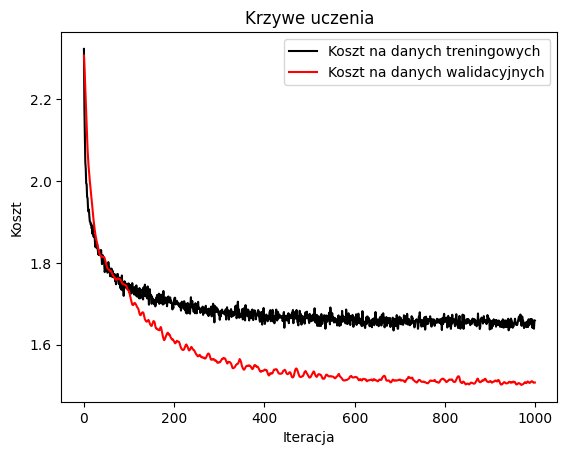

In [13]:
# ---------------- Trening sieci --------------
cnn = train_cnn(
    Xtrain=Xtrain, 
    ytrain=ytrain_ohe, 
    Xval=Xval, 
    yval=yval_ohe, 
    num_classes=num_classes,
    kernel_size=optimal_kernel_size,
    padding=optimal_padding,
    stride=optimal_stride)

Jak zwykle, sprawdź, czy na wykresie krzywych uczenia nie obserwujesz znaczącego *overfittingu* (czy krzywa dla zestawu walidacyjnego nie rośnie przy dalszym spadku krzywej dla zestawu treningowego). Jeśli wszystko jest w porządku, sprawdźmy dokładność naszego modelu także na danych testowych z zestawu MNIST!

In [14]:
# ----------------- Predykcja i sprawdzenie działania -------------------
pred = pred_cnn(Xtrain, cnn)
accuracy = np.mean(pred==ytrain)
print("Dokładność modelu na danych treningowych: "+str(accuracy*100)+'%')
pred = pred_cnn(Xval, cnn)
accuracy = np.mean(pred==yval)
print("Dokładność modelu na danych walidacyjnych: "+str(accuracy*100)+'%')
pred = pred_cnn(Xtest, cnn)
accuracy = np.mean(pred==ytest)
print("Dokładność modelu na danych testowych: "+str(accuracy*100)+'%')

Dokładność modelu na danych treningowych: 82.93135435992579%
Dokładność modelu na danych walidacyjnych: 79.10863509749304%
Dokładność modelu na danych testowych: 81.66666666666667%


## 4.2 Wykorzystanie gotowej architektury - AlexNet

Badacze tematyką klasyfikacji obrazów zajmują się od lat. Istnieje wiele gotowych architektur konwolucyjnych sieci neuronowych, które zostały wykrenowane do oceny, co znajduje się na przekazany jej obrazku. Jedną z nich jest AlexNet, wytrenowana na dużym zbiorze zdjęć ImageNet, która rozróżnia 1000 klas obiektów na zdjęciach. AlexNet składa się z pięciu warstw konwolucyjnych, trzech wastw *max pooling*, oraz trzech wastw *fully-connected* (czyli liniowych) na końcu, wewnątrz używa funkcji aktywacji ReLU, a jedynie na warstwie wyjściowej - funkcji Softmax. Tak prezentuje się jej architektura:

<div align="center">

<img src='https://i.imgur.com/PWXzmkw.jpg'/>

<font size="1">Grafika: hackmd.io / Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton, 2012 </font>
</div>

Jej implementację (wraz z wagami) można pobrać z pomocą PyTorcha. Możemy ją zaimportować do naszego projektu, pobrać etykiety klas używanych przez ImageNet (z repozytorium twórców ImageNet), a następnie dokonać klasyfikacji dowolnego zdjęcia! Musimy jedynie pamiętać, aby odpowiednio zdjęcie przekształcić: musi ono mieć wymiary 3x224x224 (oczywiście jako zdjęcie RGB, stąd 3 kanały), a także być wstępnie znormalizowane. Poniższy fragment kodu, tworzony w oparciu o tutorial [TUTAJ](https://pytorch.org/hub/pytorch_vision_alexnet/) realizuje właśnie wspomniane wyżej zadania:


In [15]:
# ---------------------- Klasyfikacja obrazów z AlexNet -----------------------------
# Import niezbędnych bibliotek
# ! python -m pip install torch==2.0.1
# ! python -m pip install numpy==1.22.3
# ! python -m pip install matplotlib==3.4.2
# ! python -m pip install wget==3.2
# ! python -m pip install PIL
# ! python -m pip install torchvision==0.15.2

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import wget
from PIL import Image
from torchvision import transforms

# Importuj AlexNet - w pełni wytrenowany model
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alexnet.eval()
# Pobierz nazwy klas, jakie posiada ImageNet
if not os.path.exists("utils/imagenet_classes.txt"):
    wget.download("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", out="utils/imagenet_classes.txt")
with open("utils/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    
# Importuj przykładowe zdjęcie psa
if not os.path.exists("utils/dog.jpg"): 
    wget.download("https://github.com/pytorch/hub/raw/master/images/dog.jpg", out="utils/dog.jpg")
# Przekształć zdjęcie, by AlexNet mógł je przetworzyć
input_image = Image.open("utils/dog.jpg")
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.2 MB 1.4 MB/s eta 0:00:01
     ---- ----------------------------------- 0.1/1.2 MB 2.1 MB/s eta 0:00:01
     ---------------------- ----------------- 0.7/1.2 MB 5.2 MB/s eta 0:00:01
     ---------------------------------------- 1.2/1.2 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2a0
    Uninstalling torchvision-0.15.2a0:
      Successfully uninstalled torchvision-0.15.2a0


Using cache found in C:\Users\Krzysiu/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Krzysiu\anaconda3\envs\ai_3_8\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Krzysiu\anaconda3\envs\ai_3_8\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Czas na Ciebie! Dokonaj klasyfikacji pobranego zdjęcia za pomocą AlexNet. Wykonaj *forward pass* na zdjęciu zapisanym w zmiennej `input_batch`, wywołując `alexnet` jak każdy inny model PyTorcha, wyszukaj klasę z najwyżej ocenionym przez AlexNet prawdopodobieństwem (wykorzystaj znów `torch.argmax`) i w pobranym słowniku etykiet `categories` wyszukaj nazwę odpowiedniej klasy. 

In [16]:
# ------------------------------ UZUPEŁNIJ KOD --------------------------------
# Dokonaj klasyfikacji zdjęcia
with torch.no_grad():
    output = alexnet(input_batch)
probabilities = torch.nn.functional.softmax(output[0], dim=0)
pred_class = torch.argmax(probabilities, dim=0)
# Odczytaj nazwę klasy
pred_category = categories[pred_class]
# -----------------------------------------------------------------------------
print("\nPredykcja: " + pred_category + " (" + str(probabilities[pred_class].numpy()) + " pewności)")


Predykcja: Samoyed (0.7244771 pewności)


Możesz oczywiście samodzielnie poeksperymentować, podmieniając zdjęcia, których klasyfikacji ma dokonać AlexNet.


## 5. Pytania kontrolne
1. Opisz bardzo krótko, na czym polega zasada działania konwolucyjnych sieci neuronowych.
2. Na co wpływa wartość hiperparametru: *kernel_size* / *padding* / *stride* ?
3. Z jakich warstw zazwyczaj składa się konwolucyjna sieć neuronowa?